In [1]:
import os

In [2]:
import pickle

In [3]:
random_seed = 42

In [4]:
import random
random.seed(random_seed)
import numpy as np
np.random.seed(random_seed)

import pandas as pd
pd.set_option('display.max_rows', 512)
pd.set_option('display.max_columns', 512)
pd.set_option('display.max_colwidth', -1)

In [5]:
import csv

In [6]:
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats('svg')

In [7]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.utils.data import Dataset

In [8]:
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
from tqdm import tqdm

In [10]:
from sklearn.metrics import classification_report

In [11]:
from scipy import stats

In [12]:
output_collections_list = []
for idx in range(0, 6000+1, 1000):
    with open("saved/score_42/{}.pkl".format(idx), "rb") as handle:
        output_collections = pickle.load(handle)    
        print(output_collections[0]['prob'])
        print(len(output_collections))
        
    if idx==0:
        output_collections_list = output_collections
    else:
        output_collections_list += output_collections
len(output_collections_list)        

[0.04337591 0.9566241 ]
1000
[0.86137784 0.13862221]
1000
[0.00470744 0.99529254]
1000
[0.0030534  0.99694663]
1000
[0.9942427  0.00575726]
1000
[0.36199945 0.63800055]
1000
[0.7558905  0.24410947]
920


6920

In [13]:
data = []
for i in output_collections_list:
    data.append([i['index'], 
                 i['influence_prime'], 
                 i['influence'], 
                 i['diff'], i['theta'], 
                 i['sentence'], i['label'], i['prediction'], i['prob'],
                 i['tokens'], i['attributions'],
                ])

df_0 = pd.DataFrame(data, columns=['sample_index', 
                                   'influence_prime', 
                                   'influence', 
                                   'diff', 'theta', 
                                   'sentence', 'label', 'prediction', 'prob', 
                                   'tokens', 'attributions'
                                  ])

df_0['theta'] = -df_0['theta']
df_0['attributions'] = -df_0['attributions']

In [14]:
drop_index = df_0[df_0['influence']<=0].index
len(drop_index)

5

In [15]:
df_0.loc[drop_index, 'influence'] = 0.0

In [16]:
df_0['rank'] = df_0['influence'].rank(method='first', ascending=False)

In [17]:
df_0['rank'].head()

0    3498.0
1    2276.0
2    3614.0
3    6020.0
4    6592.0
Name: rank, dtype: float64

In [18]:
mem_list = []
for i in range(0, 100, 10):
    k = int(len(df_0)*i/100)
    print(k)
    mem_list.append(df_0[df_0['rank']==k+1]['influence'].values[0])

0
692
1384
2076
2768
3460
4152
4844
5536
6228


In [19]:
mem_list

[14.82619571685791,
 4.184794902801514,
 1.6710580587387085,
 0.5820306539535522,
 0.18865419924259186,
 0.060171011835336685,
 0.01976732537150383,
 0.005779205355793238,
 0.0014242838369682431,
 0.0001598228991497308]

In [20]:
def read_report(output_path, order, percentage, seed, epoch, split):
    df = pd.read_csv(os.path.join(output_path, order, percentage, seed, "report/{}_{}.csv".format(epoch-1, split)))
    return df

In [21]:
original = []
for seed in [0, 1, 2, 3, 42]:
    df = read_report('saved', 'random', str(0), str(seed), 5, 'test')
    original.append(df.loc[2][1])
original

[0.885227896760022,
 0.8835804503020318,
 0.8857770455793521,
 0.8802855573860516,
 0.8813838550247117]

In [22]:
percentage_list = [
    10, 
    20, 
    30, 
    40, 
    50
                  ]

In [23]:
result_dict = {}

for order in [
    'random_0', 
    'random_2', 
    'random', 
    'mem']:
    for percentage in percentage_list:
        result_dict[order+'_'+str(percentage)] = []
        for seed in [0, 1, 2, 3, 42]:
            df = read_report('saved', order, str(percentage), str(seed), 5, 'test')
            result_dict[order+'_'+str(percentage)].append(df.loc[2][1])

In [24]:
df

,Unnamed: 0,f1-score,precision,recall,support
0,0,0.860816,0.877993,0.844298,912.000000
1,1,0.865623,0.849576,0.882288,909.000000
2,accuracy,0.863262,0.863262,0.863262,0.863262
3,macro avg,0.863220,0.863785,0.863293,1821.000000
4,weighted avg,0.863216,0.863808,0.863262,1821.000000


In [25]:
result_dict

{'random_0_10': [0.8775398132894014,
  0.8780889621087314,
  0.8797364085667215,
  0.8797364085667215,
  0.8824821526633718],
 'random_0_20': [0.8797364085667215,
  0.8786381109280615,
  0.8764415156507414,
  0.8813838550247117,
  0.8758923668314114],
 'random_0_30': [0.870950027457441,
  0.8764415156507414,
  0.8725974739154311,
  0.8797364085667215,
  0.8780889621087314],
 'random_0_40': [0.8742449203734212,
  0.8753432180120813,
  0.8764415156507414,
  0.8764415156507414,
  0.8742449203734212],
 'random_0_50': [0.8753432180120813,
  0.8682042833607908,
  0.8682042833607908,
  0.8720483250961011,
  0.8704008786381109],
 'random_2_10': [0.8841295991213619,
  0.8802855573860516,
  0.8758923668314114,
  0.8813838550247117,
  0.8786381109280615],
 'random_2_20': [0.8824821526633718,
  0.8786381109280615,
  0.8780889621087314,
  0.8769906644700713,
  0.8758923668314114],
 'random_2_30': [0.8747940691927513,
  0.8753432180120813,
  0.8736957715540912,
  0.8780889621087314,
  0.878088962108

In [26]:
random_1_mean = []
random_1_std = []

random_1_mean.append(np.mean(original)*100)
random_1_std.append(np.std(original)*100)

for percentage in percentage_list:
    result = result_dict['random_0_'+str(percentage)]
    random_1_mean.append(np.mean(result)*100)
    random_1_std.append(np.std(result)*100)

In [27]:
# random_1_mean

In [28]:
random_2_mean = []
random_2_std = []

random_2_mean.append(np.mean(original)*100)
random_2_std.append(np.std(original)*100)

for percentage in percentage_list:
    result = result_dict['random_2_'+str(percentage)]
    random_2_mean.append(np.mean(result)*100)
    random_2_std.append(np.std(result)*100)

In [29]:
# random_2_mean

In [30]:
random_mean = []
random_std = []

random_mean.append(np.mean(original)*100)
random_std.append(np.std(original)*100)

for percentage in percentage_list:
    result = result_dict['random_'+str(percentage)]
#     result = result_dict['random_'+str(percentage)] + result_dict['random_0_'+str(percentage)] + result_dict['random_2_'+str(percentage)]
    random_mean.append(np.mean(result)*100)
    random_std.append(np.std(result)*100)

In [31]:
# random_mean

In [32]:
random_mean_ = []
random_std_ = []

random_mean_.append(np.mean(original)*100)
random_std_.append(np.std(original)*100)

for percentage in percentage_list:
#     result = result_dict['random_'+str(percentage)]
    result = result_dict['random_'+str(percentage)] + result_dict['random_0_'+str(percentage)] + result_dict['random_2_'+str(percentage)]
    random_mean_.append(np.mean(result)*100)
    random_std_.append(np.std(result)*100)

In [33]:
random_mean_

[88.32509610104339,
 88.07614863628042,
 87.85648910854842,
 87.62218561230094,
 87.53798279333701,
 87.20117151748124]

In [34]:
88.32509610104339-87.62218561230094

0.7029104887424467

In [35]:
mem_mean = []
mem_std = []

mem_mean.append(np.mean(original)*100)
mem_std.append(np.std(original)*100)

for percentage in percentage_list:
    result = result_dict['mem_'+str(percentage)]
    mem_mean.append(np.mean(result)*100)
    mem_std.append(np.std(result)*100)

In [36]:
mem_mean

[88.32509610104339,
 87.52333882482152,
 87.2158154859967,
 86.88632619439869,
 86.79846238330586,
 86.43602416254807]

In [37]:
mem_std

[0.21296781361521705,
 0.27214742873946013,
 0.1750398402032878,
 0.1750398402032861,
 0.14570564702275107,
 0.06015623915487719]

In [38]:
88.32509610104339-86.88632619439869

1.4387699066446942

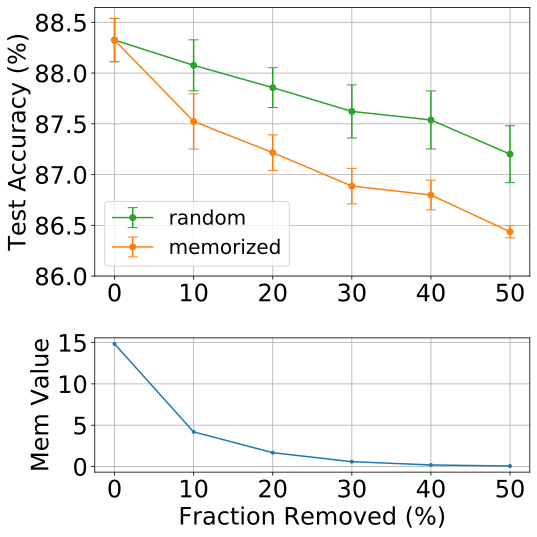

In [39]:
matplotlib.rcParams.update({'font.size': 24})

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})

x = range(0, 60, 10)

ax0.errorbar(x, random_mean_, 
            yerr=random_std_, 
            linestyle='-', 
            fmt='o', label='random', color='tab:green', capsize=5)
ax0.errorbar(x, mem_mean, 
            yerr=mem_std, 
            linestyle='-', fmt='o', label='memorized', color='tab:orange', capsize=5)

ax0.legend(fontsize=20)

ax0.set_ylabel('Test Accuracy (%)')
ax0.set_xticks(x)

ax0.set_yticks(np.arange(np.round(min(random_mean_+mem_mean), 0), np.round(max(random_mean_+mem_mean), 0)+1.0, 0.5))

ax0.grid(True)


ax1.set_xlabel('Fraction Removed (%)')
ax1.set_ylabel('Mem Value')
ax1.set_xticks(x)
ax1.set_yticks(np.arange(0, df_0['influence'].max()+5, 5))



ax1.plot(x, mem_list[0: len(x)], color='tab:blue', marker='.')
ax1.grid(True)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.show()

filename = "saved/vis/Marginal_SST.pdf"
os.makedirs(os.path.dirname(filename), exist_ok=True)  

plt.savefig(filename, bbox_inches='tight', pad_inches=0.1)  